### Table Extraction 

We propose a machine learning approach for table detection which can be broken down into 4 units:

- $\textbf{Candidates generation}$: Given a pdf document, we first generate a set of candidate regions for tables. To generate those candidates, we analyze alignment of text and position of lines. Here we reload our candidates since canditate generation can be computationally expensive.

- $\textbf{Features Extraction}$: For each candidate region, we extract a set of features (24 in total). This is a crucial step compared to heuristic based approaches since we can use any type of features, even those which are very specific. The algorithm will learn which features are significant. 

- $\textbf{Labels generation}$: This steps allows us to build a label vector of 0 and 1. To do so, we compute the intersection of union (IOU, in terms of area) between a candidate region and ground truth tables. If IOU is greater than some threshold (currently 0.8), we label the candidate as a true table region. 

- $\textbf{Candidates Classification}$: We then train a machine learning classifier to predict whether a candidate region is a table or not. We use a logistic regression model for this task.

This notebook is provided to go through the different steps of the table detection tool. However, to detect tables in documents, the user should directly use the command line with the command python $\textbf{extract_tables.py --test-pdf pdf_list}$ in the table-extraction/ml/ folder. pdf_list should be a text file containing a list of pdf files that must be saved in the os.environ['DATAPATH'] folder. This environment variable is set when running source set_env.sh and can be changed. The script will generate a pdf_list.bbox where each row contains the detected tables for the corresponding document in pdf_list (row to row mapping). The bounding boxes are saved in the format (page_number, page_width, page_height, top, left, bottom, right). This .bbox file can be use to run evaluation with $\textbf{python char_level_evaluation.py  pdf_list pdf_list.bbox gt_bbox}$. This char_level_evaluation.py script will compute recall, precision and F1 for the sub-objects level (characters in text). gt_bbox is the file containing the ground truth tables. We provided examples of these files in the $\textbf{data/paleo/ml/}$ folder.

### Please run source set_env.sh from the home folder before using this notebook. 

In [1]:
import pickle
import numpy as np
import os
from ml.TableExtractML import TableExtractorML
from ml.extract_tables import load_train_data, load_test_data, get_bboxes_from_line, filter_bboxes, load_model, bbox_to_dict

## Step 1: Load the data (candidates, features and labels)

We first define the path to the file containing the list of pdf files to analyze

In [2]:
test_pdf = os.environ['MLPATH'] + 'test.pdf.list.paleo.not.scanned'

We then call a load_test_data function to extract the test features. If a test_pdf.features.pkl file is found, the load data function will just reload pre-computed features. Otherwise it will recompute those features for the test documents listed in the test_pdf file and save them in .features.pkl file. 

In [3]:
X_test, tables_test = load_test_data(test_pdf)

Loading precomputed features for /Users/ineschami/Desktop/TreeStructure/data/paleo/ml/test.pdf.list.paleo.not.scanned..
Features loaded!


The matrix X_test has shape nb_candidates x nb_features and contains all the 24 features for each region candidate. tables_test is a matrix of shape nb_candidates x 8 where each row contains information about a table (pdf_id, page_number, page_width, page_height, top, loft, bottom, right). There is a one to one mapping between the rows of X_test and the rows of tables_test. 

In [4]:
print X_test.shape
print tables_test.shape
print "Number of candidates generated for {} test documents: {}".format(len(np.unique(tables_test[:,0])), X_test.shape[0])

(2715, 24)
(2715, 8)
Number of candidates generated for 32 test documents: 2715


In [5]:
# todo : compute proportion of true candidates + error analysis (pattern in tables missing)

### Display Candidates

We pick a test pdf file and create an extractor object. This extractor can parse the pdf to extract words coordinates and is used to display the generated candidates on the top of the original pdf.

In [6]:
test_pdf_names = [name.rstrip() for name in open(test_pdf).readlines()]
pdf_file = '1-s2.0-S0016699515000601-main.pdf'
# other test example
# pdf_file = '1-s2.0-S0016703711007290-main.pdf'
pdf_number = test_pdf_names.index(pdf_file)
extractor = TableExtractorML(os.environ['DATAPATH'] + pdf_file)
extractor.parse()

In [7]:
# get candidates for the corresponding pdf document 
candidates_indices = np.argwhere(tables_test[:,0]==pdf_number).flatten()
candidates = tables_test[candidates_indices, 1:]

Page number : 1


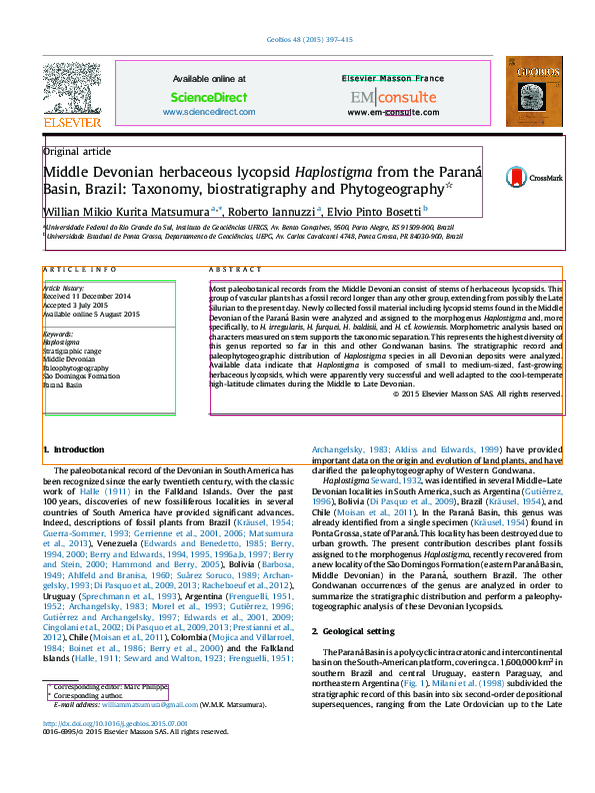

In [8]:
page_num = 1 # you can play with this to display candidates for different pages 
print "Page number : {}".format(page_num)
candidates_within_page = [bbox for bbox in candidates if bbox[0]==page_num]
extractor.display_bounding_boxes(page_num, candidates_within_page)

## Step 2: Predict table regions using a pretrained model 

We now predict the table regions using a pretrained model. The script extract_tables.py will look for a pickled model in the default model_path (os.environ['MLPATH'] + 'model.pkl'). If no model is found, a model will be trained using the train pdf and the corresponding ground truth tables (train_pdf and gt_train arguments). Here we reload our pretrained model.

In [9]:
# load the model 
model_path =  os.environ['MLPATH'] + 'model.pkl'
model = load_model(model_path)

Loading pretrained model...
Model loaded!


### Prediciton Results 

In [10]:
# predict tables
y_pred = model.predict(X_test)

### Display detected tables

In [11]:
# Extract candidate labeled as tables
predicted_tables = tables_test[np.flatnonzero(y_pred)]
# creat a dict mapping pdf_id to extracted tables
pdf_idx_to_filtered_bboxes = bbox_to_dict(predicted_tables)

The function filter_bboxes will return a dictionnary with the pdf row number as keys and the list of tables detected within that pdf document in the format (page_number, page_width, page_height, top, left, bottom, right). We can use this dict to display the detected tables. 

Page number : 9


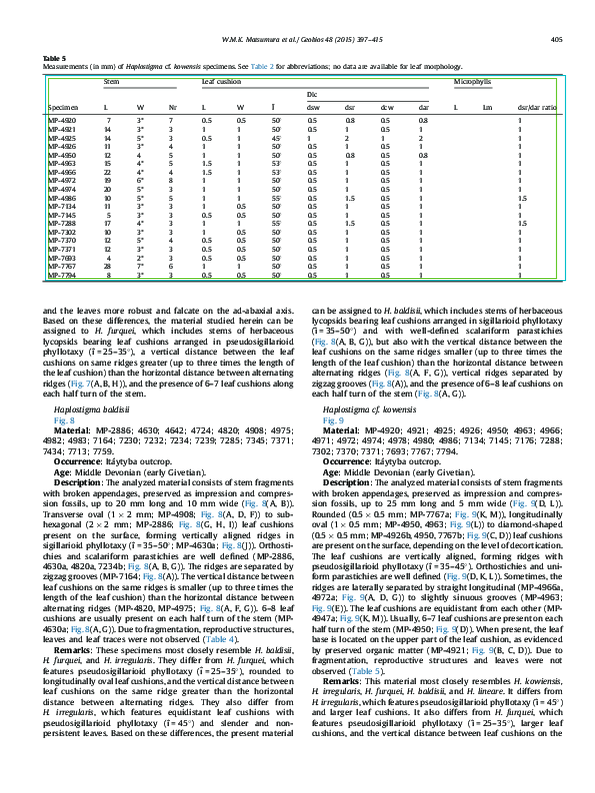

In [12]:
page_num = 9  # pages with tables: 5, 7, 8, 9, 13
print "Page number : {}".format(page_num)
tables_within_page = [bbox for bbox in pdf_idx_to_filtered_bboxes[pdf_number] if bbox[0]==page_num]
extractor.display_bounding_boxes(page_num, tables_within_page)

In [13]:
pdf_idx_to_filtered_bboxes

{1: [(5, 595, 793, 140, 50, 690, 504)],
 2: [(4, 595, 793, 252, 48, 633, 556), (4, 595, 793, 250, 45, 640, 565)],
 3: [(9, 612, 810, 387, 47, 451, 554), (9, 612, 810, 385, 40, 455, 560)],
 4: [(5, 595, 793, 542, 48, 738, 556),
  (5, 595, 793, 540, 45, 740, 565),
  (7, 595, 793, 503, 48, 738, 556),
  (7, 595, 793, 500, 45, 740, 565),
  (8, 595, 793, 78, 33, 553, 547),
  (8, 595, 793, 75, 35, 555, 555),
  (8, 595, 793, 85, 95, 425, 170),
  (8, 595, 793, 85, 195, 425, 420),
  (8, 595, 793, 100, 300, 435, 420),
  (9, 595, 793, 78, 48, 278, 556),
  (9, 595, 793, 75, 45, 280, 565),
  (13, 595, 793, 316, 48, 738, 557),
  (13, 595, 793, 310, 45, 740, 565)],
 6: [(5, 595, 793, 272, 61, 513, 288),
  (5, 595, 793, 270, 60, 515, 290),
  (6, 595, 793, 93, 55, 334, 282),
  (6, 595, 793, 90, 55, 335, 280),
  (7, 595, 793, 92, 61, 190, 540),
  (7, 595, 793, 269, 61, 393, 540),
  (7, 595, 793, 90, 60, 395, 540),
  (8, 595, 793, 302, 55, 385, 533),
  (9, 595, 793, 479, 61, 692, 540),
  (9, 595, 793, 475